In [1]:
import geopandas as gpd 
import pandas as pd
from blocksnet import City, Provision, ProvisionMethod

In [2]:
blocks = gpd.read_file('data/data_lu/blocks_best_feature.gpkg')
# blocks = gpd.read_file('data/data_lu/MSK_blocks_best_feature.gpkg')


In [ ]:
pd.set_option('display.max_columns', None)
blocks.reset_index

,id,land_use,is_living,build_floor_area,living_demand,living_area,share_living,business_area,share_business,site_area,population,footprint_area,fsi,gsi,l,osr,mxi,best_example,connectivity,density,diversity,centrality,cenrality_population,500m_water,10km_airport,1250m_metro,5km_train,znop_area,geometry
0,0,None,1,43840.686518,50.641057,30688.480678,2.199357,13152.205840,0.942581,8.044667e+05,606,13953.390266,0.054497,0.017345,3.141938,18.031500,0.700000,None,84.68750,0.000005,1.386294,0.241649,0.30,1,1,0,1,254455.0,"MULTIPOLYGON (((354918.622 6625258.829, 354901..."
1,1,transport,1,10294.395525,53.114392,2177.690063,0.431105,8116.705462,1.606820,2.317313e+04,41,5051.410558,0.444238,0.217986,2.037925,1.760348,0.211541,None,81.62500,0.000129,0.636514,0.148119,1.15,0,0,0,1,NaN,"MULTIPOLYGON (((355412.142 6623378.149, 355411..."
2,2,recreation,1,1173.871643,58.693582,821.710142,0.706252,352.161501,0.302679,3.630058e+05,14,1163.480697,0.003234,0.003205,1.008931,308.246934,0.700000,None,78.56250,0.000003,0.000000,0.065771,0.39,1,1,0,0,316405.0,"MULTIPOLYGON (((353934.329 6625429.433, 353923..."
3,3,residential,1,46303.954706,52.660044,30595.485797,2.760046,15708.468909,1.417075,1.964145e+05,581,11085.135352,0.235746,0.056437,4.177121,4.002452,0.660753,None,81.31250,0.000015,1.098612,0.202092,0.80,0,1,0,1,NaN,"MULTIPOLYGON (((355099.099 6623847.765, 355074..."
4,4,recreation,1,153749.574111,53.097680,106407.750936,2.352959,47341.823175,1.046854,1.781752e+06,2004,45222.959595,0.086291,0.025381,3.399812,11.294526,0.692085,None,93.00000,0.000006,1.609438,0.280980,0.81,1,1,0,1,NaN,"MULTIPOLYGON (((352766.168 6621954.748, 352744..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16332,12307,None,1,249287.917054,19.491024,142070.072327,2.476133,107217.844728,1.868695,3.290414e+05,7289,57375.785357,0.757619,0.174373,4.344828,1.089767,0.569904,None,63.93750,0.000024,0.376770,0.089278,NaN,1,0,0,1,NaN,"MULTIPOLYGON (((357888.606 6649807.767, 357904..."
16333,1329,business,1,496909.134279,29.785990,11854.824219,0.044054,485054.310060,1.802523,9.906615e+05,398,269097.496353,0.501593,0.271634,1.846577,1.452104,0.023857,None,50.43750,0.000024,1.905732,0.252771,1.49,1,0,1,1,NaN,"MULTIPOLYGON (((352251.207 6642318.712, 352267..."
16334,11722,residential,1,449497.560132,33.638989,289396.225630,5.926781,160101.334502,3.278846,2.957626e+05,8603,48828.567203,1.519792,0.165094,9.205627,0.549356,0.643822,transport,55.46875,0.000142,1.893730,0.260035,2.91,0,0,1,0,NaN,"MULTIPOLYGON (((343787.986 6653005.585, 343796..."
16335,12309,residential,0,56086.341648,NaN,0.000000,0.000000,56086.341648,2.450255,7.911875e+04,0,22890.003324,0.708888,0.289312,2.450255,1.002539,0.000000,transport,52.87500,0.000114,1.831020,0.248322,1.03,0,0,1,0,NaN,"MULTIPOLYGON (((344003.091 6653433.284, 343995..."


# classificator

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
blocks['perimeter'] = blocks.geometry.length

In [ ]:
import numpy as np
def compute_geometric_features(gdf):
    """
    Вычисление геометрических характеристик, включая количество вершин.
    """
    # Вычисляем стандартные характеристики
    gdf['compactness'] = (4 * np.pi * gdf['site_area']) / (gdf['perimeter'] ** 2)
    gdf['bounding_box'] = gdf['geometry'].apply(lambda x: x.minimum_rotated_rectangle)

    def calculate_length_and_width(polygon):
        coords = list(polygon.exterior.coords)
        side_lengths = [np.linalg.norm(np.array(coords[i]) - np.array(coords[i - 1])) for i in range(1, len(coords))]
        return max(side_lengths), min(side_lengths)

    gdf[['length', 'width']] = gdf['bounding_box'].apply(lambda x: pd.Series(calculate_length_and_width(x)))

    gdf['centroid_x'] = gdf['geometry'].centroid.x
    gdf['centroid_y'] = gdf['geometry'].centroid.y

    gdf['area_perimeter_ratio'] = gdf['site_area'] / gdf['perimeter']

    def count_vertices(geometry):
        if geometry.is_empty or geometry is None:
            return 0
        if geometry.type == 'Polygon':
            return len(geometry.exterior.coords)
        if geometry.type == 'MultiPolygon':
            return sum(len(polygon.exterior.coords) for polygon in geometry.geoms)
        return 0

    gdf['vertex_count'] = gdf.geometry.apply(count_vertices)
    gdf['convex_hull'] = gdf['geometry'].convex_hull
    gdf['convex_hull_area'] = gdf['convex_hull'].area
    gdf['convexity_ratio'] = gdf['site_area'] / gdf['convex_hull_area']
    gdf['centroid_distance_from_origin'] = np.sqrt(gdf['centroid_x']**2 + gdf['centroid_y']**2)

    return gdf.drop(columns=['bounding_box', 'convex_hull'])

blocks = compute_geometric_features(blocks)



In [6]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from collections import Counter

def compute_landuse_shares(gdf, buffer_distance=500, landuse_col='land_use'):
    gdf = gdf.reset_index(drop=True)
    sindex = gdf.sindex
    shares_list = []

    for idx, row in gdf.iterrows():
        geom = row.geometry
        buffer = geom.buffer(buffer_distance)

        possible_matches_index = list(sindex.intersection(buffer.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        neighbors = possible_matches[possible_matches.index != idx]
        neighbors = neighbors[neighbors.geometry.intersects(buffer)]

        landuses = neighbors[landuse_col]
        total = len(landuses)

        if total > 0:
            landuse_counts = Counter(landuses)
            landuse_shares = {f"{k}_share": v / total for k, v in landuse_counts.items()}
        else:
            landuse_shares = {}

        shares_list.append(landuse_shares)

    shares_df = pd.DataFrame(shares_list).fillna(0)
    return pd.concat([gdf, shares_df], axis=1)

blocks = compute_landuse_shares(blocks)

In [ ]:
blocks[['land_use', 'geometry']].explore('land_use')

In [130]:
from sklearn.preprocessing import MinMaxScaler

new = blocks[['site_area',
        'connectivity',
        'centrality',
        '500m_water', '10km_airport','gsi', 'osr', 'mxi',
        '5km_train' ,'land_use', 'compactness', 
       'vertex_count', 'convexity_ratio','residential_share', 'transport_share', 'industrial_share',
       'business_share', 'agriculture_share', 'special_share',
       'recreation_share', 'best_example']].copy()

cols_to_fill = ['connectivity',
                'centrality', 'gsi', 'osr', 'mxi']
new[cols_to_fill] = new[cols_to_fill].fillna(0)


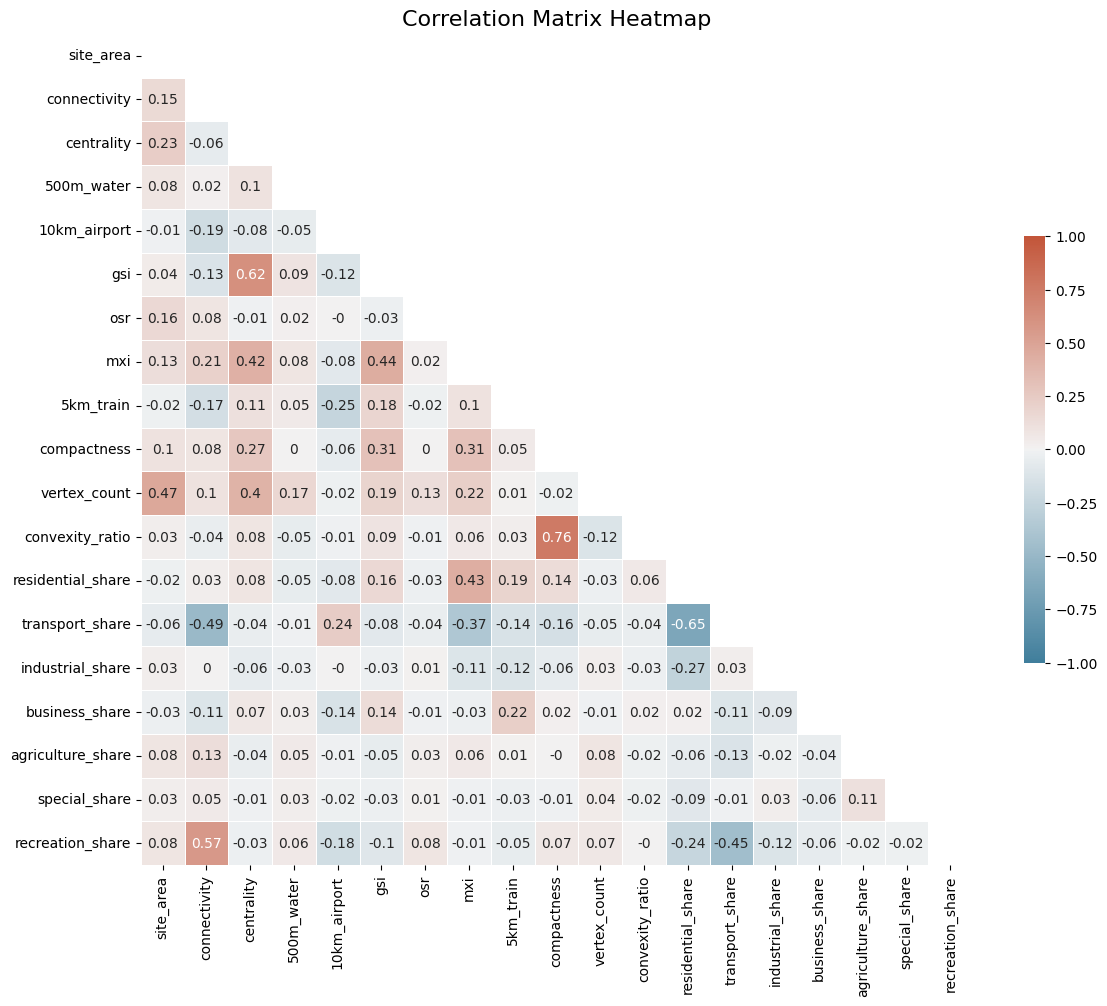

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the correlation matrix
corr_matrix = new.drop(axis=1, columns=['land_use', 'best_example']).corr().round(2)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a mask for the upper triangle (optional, for better readability)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Adjust the plot
plt.tight_layout()
plt.title('Correlation Matrix Heatmap', fontsize=16)

# Show the plot
plt.show()


In [98]:
# Удаляем строки с пропущенным land_use
df = new.dropna(subset=['land_use']).copy()

# Удалим geometry и id, чтобы не мешали
# df = df.drop(columns=['geometry', 'best_example'])

# Категориальную переменную переведём в числовую
df['land_use'] = df['land_use'].astype('category')
df['land_use_code'] = df['land_use'].cat.codes

X = df.drop(columns=['land_use', 'land_use_code', 'best_example'])
y = df['land_use_code']
y_not_code = df['land_use']

X = X.fillna(X.median(numeric_only=True))


In [99]:
scaler = StandardScaler()
X_index = df.index
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X_index)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# model = RandomForestClassifier(n_estimators=100, random_state=42,)
# model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# model.fit(X_train, y_train)
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=4000,
    learning_rate=0.01,
    l2_leaf_reg=2,
    depth=9,
    random_seed=777,
    verbose=500,           # отключает лог CatBoost
    auto_class_weights='Balanced'  # аналог class_weight='balanced'
)

model.fit(X_train, y_train)


0:	learn: 1.9240756	total: 290ms	remaining: 19m 20s
500:	learn: 0.4385254	total: 1m 5s	remaining: 7m 35s
1000:	learn: 0.2898664	total: 2m 9s	remaining: 6m 28s
1500:	learn: 0.2251655	total: 3m 14s	remaining: 5m 23s
2000:	learn: 0.1864898	total: 4m 19s	remaining: 4m 18s
2500:	learn: 0.1594040	total: 5m 24s	remaining: 3m 14s
3000:	learn: 0.1407541	total: 6m 29s	remaining: 2m 9s
3500:	learn: 0.1256298	total: 7m 33s	remaining: 1m 4s
3999:	learn: 0.1132278	total: 8m 37s	remaining: 0us


In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df['land_use'].cat.categories))




'''
Обучение на МСК

              precision    recall  f1-score   support

 agriculture       0.59      0.68      0.63       199
    business       0.00      0.00      0.00         3
  industrial       0.19      0.19      0.19        47
  recreation       0.83      0.76      0.79       627
 residential       0.81      0.87      0.84       611
     special       0.71      0.25      0.37        20
   transport       0.73      0.48      0.58        23

    accuracy                           0.77      1530
   macro avg       0.55      0.46      0.49      1530
weighted avg       0.77      0.77      0.76      1530

'''

'''
Обучение МСК, весь СПб

              precision    recall  f1-score   support

 agriculture       0.06      0.37      0.10       125
    business       0.00      0.00      0.00       299
  industrial       0.38      0.15      0.21       503
  recreation       0.11      0.65      0.19      1895
 residential       0.73      0.50      0.60      5516
     special       0.00      0.00      0.00        77
   transport       1.00      0.00      0.00      7741

    accuracy                           0.26     16156
   macro avg       0.33      0.24      0.16     16156
weighted avg       0.75      0.26      0.23     16156

'''


'''
SPb Polina

              precision    recall  f1-score   support

 agriculture       0.59      0.74      0.65        23
    business       0.47      0.47      0.47        57
  industrial       0.59      0.67      0.63        96
  recreation       0.74      0.81      0.77       369
 residential       0.91      0.86      0.89      1079
     special       0.40      0.29      0.33        14
   transport       0.76      0.82      0.79       261

    accuracy                           0.82      1899
   macro avg       0.64      0.66      0.65      1899
weighted avg       0.82      0.82      0.82      1899

'''

In [114]:
# добавляем вероятность ленд-юзов
import numpy as np
import pandas as pd

# Предсказанные вероятности для всех объектов X_scaled
probas = model.predict_proba(X_scaled)

# Получаем категории land_use (например, 'agriculture', 'business', 'industrial', ...)
class_labels = df['land_use'].cat.categories

# Создаём DataFrame с вероятностями, используя индексы исходного DataFrame (df)
proba_df = pd.DataFrame(probas, 
                        columns=[f'prob_{cls}' for cls in class_labels],
                        index=df.index)
merged_fin = blocks.join(proba_df, how='left')


# Добавляем колонку с наиболее вероятной меткой класса
# Находим индекс максимальной вероятности для каждой строки
prob_columns = [f'prob_{cls}' for cls in class_labels]
merged_fin['most_probable_class_idx'] = merged_fin[prob_columns].values.argmax(axis=1)

# Преобразуем индекс в метку класса
merged_fin['most_probable_class'] = merged_fin['most_probable_class_idx'].apply(
    lambda idx: class_labels[idx] if pd.notna(idx) else None
)

# Если нужно, можно удалить вспомогательную колонку с индексом
merged_fin.drop('most_probable_class_idx', axis=1, inplace=True)

# Добавляем колонку с максимальной вероятностью
merged_fin['max_probability'] = merged_fin[prob_columns].max(axis=1)

In [145]:
merged_fin.columns

Index(['id', 'land_use', 'is_living', 'build_floor_area', 'living_demand',
       'living_area', 'share_living', 'business_area', 'share_business',
       'site_area', 'population', 'footprint_area', 'fsi', 'gsi', 'l', 'osr',
       'mxi', 'best_example', 'connectivity', 'density', 'diversity',
       'centrality', 'cenrality_population', '500m_water', '10km_airport',
       '1250m_metro', '5km_train', 'znop_area', 'geometry', 'perimeter',
       'compactness', 'length', 'width', 'centroid_x', 'centroid_y',
       'area_perimeter_ratio', 'vertex_count', 'convex_hull_area',
       'convexity_ratio', 'centroid_distance_from_origin', 'transport_share',
       'residential_share', 'recreation_share', 'industrial_share',
       'special_share', 'agriculture_share', 'business_share', 'None_share',
       'prob_agriculture', 'prob_business', 'prob_industrial',
       'prob_recreation', 'prob_residential', 'prob_special', 'prob_transport',
       'most_probable_class', 'max_probability'],
    

In [147]:
merged_fin.loc[:100, ['land_use','geometry', 'prob_agriculture', 'prob_business', 'prob_industrial',
       'prob_recreation', 'prob_residential', 'prob_special', 'prob_transport',
       'most_probable_class', 'max_probability']].explore()

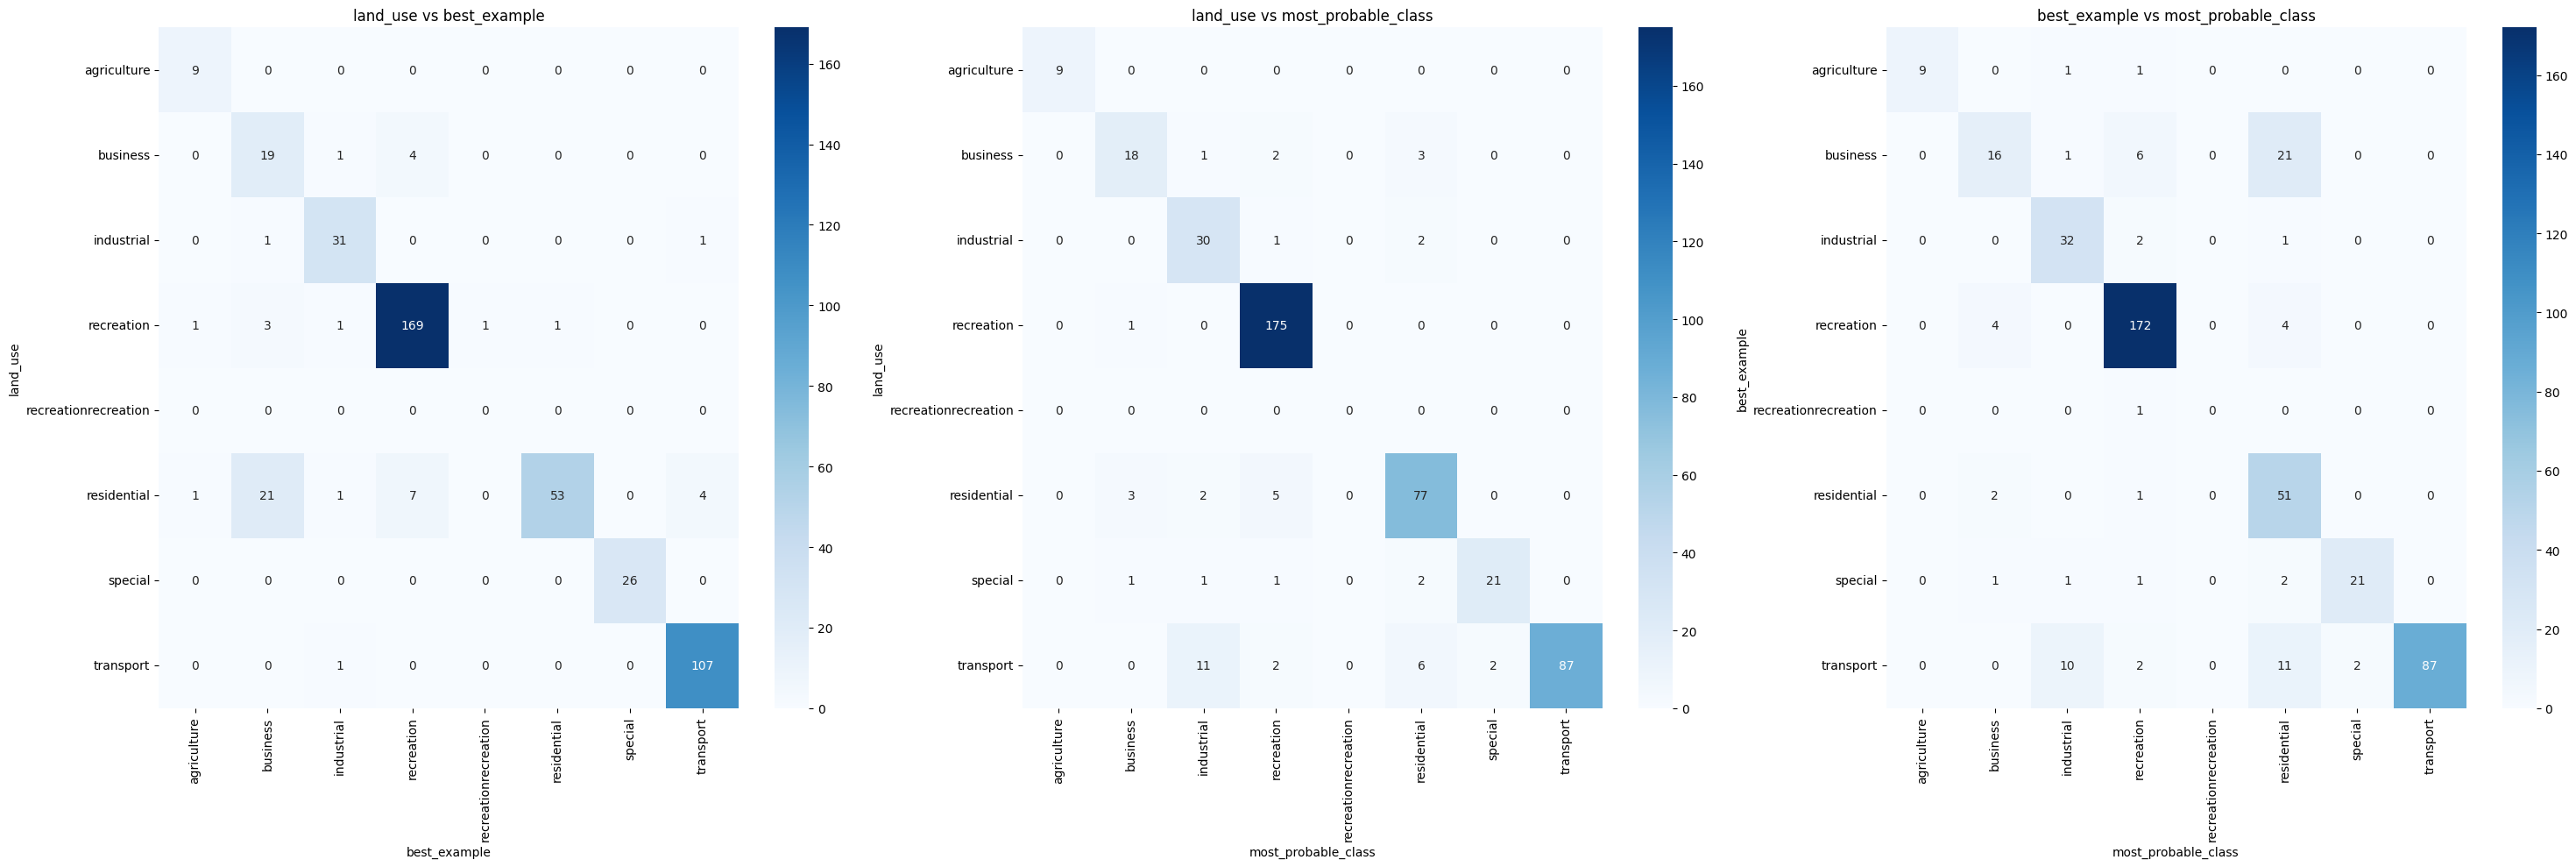

Accuracy (land_use vs best_example):            89.4%
Accuracy (land_use vs most_probable_class):     90.1%
Accuracy (best_example vs most_probable_class): 83.8%


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Filter the DataFrame to keep only rows where 'best_example' is not null
filtered_df = merged_fin[merged_fin['best_example'].notna()][['land_use', 'best_example', 'most_probable_class']]

# Drop rows with any missing values in the three columns
filtered_df = filtered_df.dropna()

# Get all unique categories across the three columns
all_categories = sorted(list(set(
    filtered_df['land_use'].unique().tolist() + 
    filtered_df['best_example'].unique().tolist() + 
    filtered_df['most_probable_class'].unique().tolist()
)))

# Create a figure with 3 subplots for the 3 confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# 1. Confusion matrix: land_use vs best_example
cm1 = confusion_matrix(
    filtered_df['land_use'], 
    filtered_df['best_example'],
    labels=all_categories
)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=all_categories, yticklabels=all_categories)
axes[0].set_title('land_use vs best_example')
axes[0].set_xlabel('best_example')
axes[0].set_ylabel('land_use')

# 2. Confusion matrix: land_use vs most_probable_class
cm2 = confusion_matrix(
    filtered_df['land_use'], 
    filtered_df['most_probable_class'],
    labels=all_categories
)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=all_categories, yticklabels=all_categories)
axes[1].set_title('land_use vs most_probable_class')
axes[1].set_xlabel('most_probable_class')
axes[1].set_ylabel('land_use')

# 3. Confusion matrix: best_example vs most_probable_class
cm3 = confusion_matrix(
    filtered_df['best_example'], 
    filtered_df['most_probable_class'],
    labels=all_categories
)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=all_categories, yticklabels=all_categories)
axes[2].set_title('best_example vs most_probable_class')
axes[2].set_xlabel('most_probable_class')
axes[2].set_ylabel('best_example')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Calculate and print accuracies
accuracy1 = np.trace(cm1) / np.sum(cm1)
accuracy2 = np.trace(cm2) / np.sum(cm2)
accuracy3 = np.trace(cm3) / np.sum(cm3)

print(f"Accuracy (land_use vs best_example):            {accuracy1*100:.1f}%")
print(f"Accuracy (land_use vs most_probable_class):     {accuracy2*100:.1f}%")
print(f"Accuracy (best_example vs most_probable_class): {accuracy3*100:.1f}%")


In [20]:
# 1. Получаем названия классов из имён колонок prob_*
proba_cols = [col for col in merged_fin.columns if col.startswith('prob_')]
class_labels = [col.replace('prob_', '') for col in proba_cols]

# 2. Преобразуем вероятности в numpy-массив
proba_matrix = merged_fin[proba_cols].values

# 3. Индексы топ-1 и топ-2 по убыванию
top_sorted_idx = np.argsort(proba_matrix, axis=1)[:, ::-1]
top1_idx = top_sorted_idx[:, 0]
top2_idx = top_sorted_idx[:, 1]

# 4. Преобразуем индексы в названия классов
top1_labels = [class_labels[i] for i in top1_idx]
top2_labels = [class_labels[i] for i in top2_idx]

# 5. Добавляем в DataFrame
merged_fin['top1_land_use'] = top1_labels
merged_fin['top2_land_use'] = top2_labels


In [21]:
# отбираем переходные лу
import numpy as np

# Получаем имена колонок с вероятностями
proba_cols = [col for col in merged_fin.columns if col.startswith('prob_')]

# Получаем вероятности как numpy-массив
proba_matrix = merged_fin[proba_cols].values

# Сортируем вероятности по убыванию
sorted_probas = np.sort(proba_matrix, axis=1)[:, ::-1]

# Вычисляем разницу между top1 и top2
margin = sorted_probas[:, 0] - sorted_probas[:, 1]

# Индексы объектов, у которых разница < 0.2
low_margin_indices = np.where(margin < 0.2)[0]

# Извлекаем строки из merged_fin
low_diff = merged_fin.iloc[low_margin_indices]

In [ ]:
low_diff['top1_geometry'] = low_diff.geometry.buffer(-30)
low_diff['top2_geometry'] = low_diff.geometry.buffer(30)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from branca.colormap import LinearColormap

# Копируем слой с буфером для top2
gdf_top2 = low_diff.copy()
gdf_top2.set_geometry('top2_geometry', inplace=True)

# Копируем слой с оригинальной геометрией для top1
gdf_top1 = low_diff.copy()
gdf_top1.set_geometry('top1_geometry', inplace=True)

# Получаем уникальные категории (классы land_use)
all_classes = pd.concat([
    gdf_top1['top1_land_use'],
    gdf_top2['top2_land_use']
]).unique()

# Назначим цвета (можно взять больше цветов при необходимости)
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

cmap = get_cmap('tab10', len(all_classes))
color_dict = {cls: to_hex(cmap(i)) for i, cls in enumerate(all_classes)}

# Добавляем цвета в каждый GeoDataFrame
gdf_top1['color'] = gdf_top1['top1_land_use'].map(color_dict)
gdf_top2['color'] = gdf_top2['top2_land_use'].map(color_dict)

# 1. Список всех колонок с вероятностями
gdf_top1[proba_cols] = gdf_top1[proba_cols].round(2)
gdf_top2[proba_cols] = gdf_top2[proba_cols].round(2)
proba_cols = [col for col in gdf_top1.columns if col.startswith('prob_')]

# 2. Добавим к tooltips
tooltip_top1 = ['top1_land_use'] + proba_cols
tooltip_top2 = ['top2_land_use'] + proba_cols

# 3. Отображаем top1 слой (как основной)
m = gdf_top2.explore(
    color=gdf_top2['color'],
    tooltip=tooltip_top2,
    name="Top-2 Prediction",
    legend=False,
    tiles="CartoDB positron"
)

# 4. Добавляем top2 слой (буферный)
gdf_top1.explore(
    m=m,
    color=gdf_top1['color'],
    tooltip=tooltip_top1,
    name="Top-1 Prediction",
    legend=False
)

# 5. Общая легенда
from branca.element import Element

legend_entries = ''.join(
    f'<i style="background:{color};width:12px;height:12px;display:inline-block;margin-right:4px;"></i>{cls}<br>'
    for cls, color in color_dict.items()
)

legend_html = f"""
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: auto;
            background-color: white; border:2px solid grey; z-index:9999;
            padding: 10px; font-size:14px;">
<b>Land Use Legend</b><br>
{legend_entries}
</div>
"""

m.get_root().html.add_child(Element(legend_html))
m
# m.save('map.html')


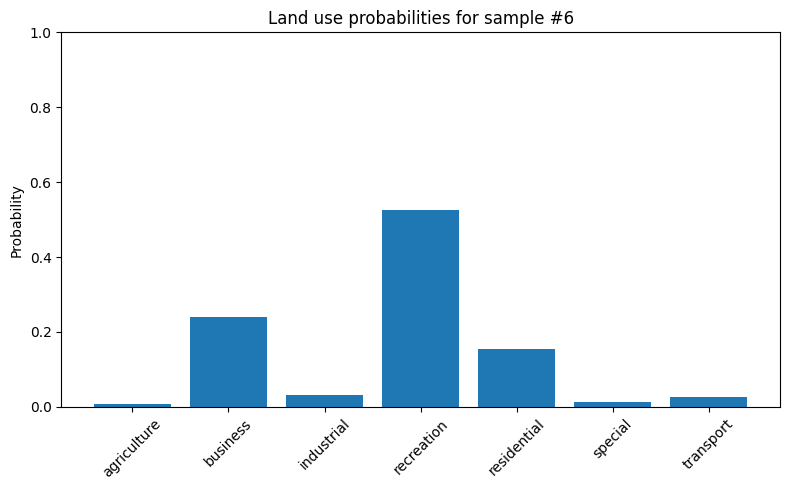

In [23]:
probas = model.predict_proba(X_scaled)

import matplotlib.pyplot as plt

i = 6  # индекс нужного объекта (41,1030)
probs = model.predict_proba(X[i:i+1])[0]
# Получаем текстовые метки land_use
class_labels = df['land_use'].cat.categories

plt.figure(figsize=(8, 5))
plt.bar(class_labels, probs)
plt.ylabel("Probability")
plt.title(f"Land use probabilities for sample #{i}")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


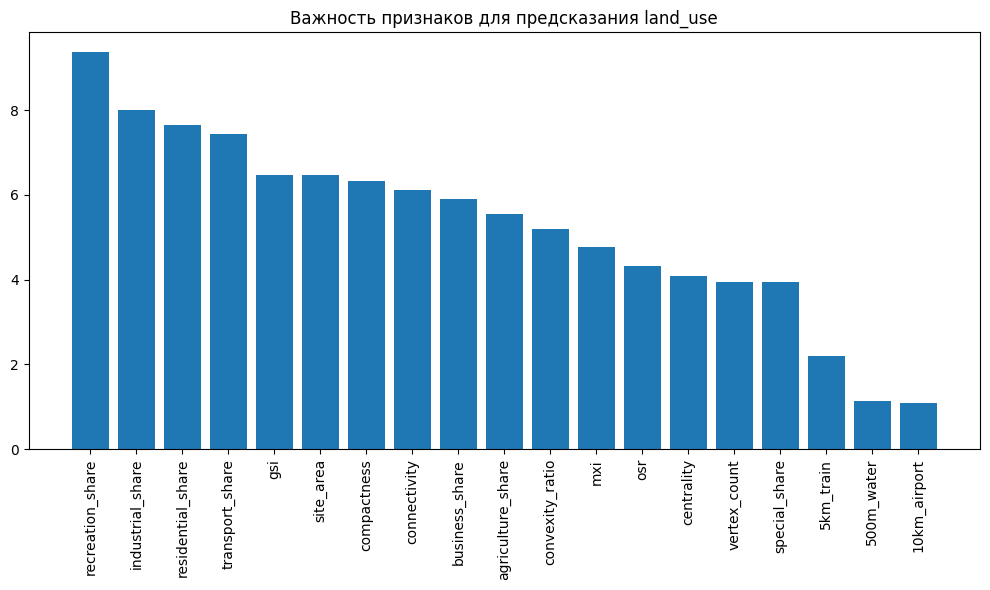

In [139]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Важность признаков для предсказания land_use")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Оставим только числовые колонки
numeric_cols = new.select_dtypes(include='number')

# Корреляционная матрица
corr = numeric_cols.corr()

# Визуализация
plt.figure(figsize=(8, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Корреляция')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Корреляционная матрица")
plt.tight_layout()
plt.show()


## Graph

In [150]:
'prob_agriculture', 'prob_business', 'prob_industrial', 'prob_recreation', 'prob_residential', 'prob_special', 'prob_transport',

('prob_agriculture',
 'prob_business',
 'prob_industrial',
 'prob_recreation',
 'prob_residential',
 'prob_special',
 'prob_transport')

<Figure size 1980x1080 with 0 Axes>

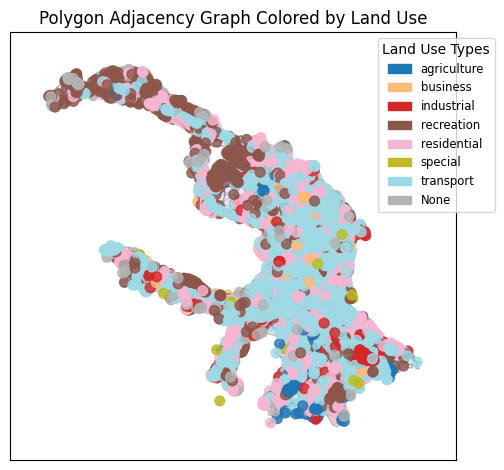

Number of nodes: 16337
Number of edges: 53471
Average degree: 6.55
Number of unique land use types: 7
prob_agriculture: mean=0.0108, max=0.9992
prob_business: mean=0.0333, max=0.9950
prob_industrial: mean=0.0472, max=0.9988
prob_recreation: mean=0.1432, max=0.9993
prob_residential: mean=0.3197, max=0.9998
prob_special: mean=0.0072, max=0.9964
prob_transport: mean=0.4276, max=0.9991


In [ ]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Step 1: Calculate centroids for each polygon
merged_fin['centroid'] = merged_fin.geometry.centroid

# Step 2: Find adjacent polygons
# Create a spatial index for efficient spatial queries
spatial_index = merged_fin.sindex

# Function to find adjacent polygons
def find_neighbors(gdf):
    neighbors = {}
    for idx, geom in enumerate(gdf.geometry):
        # Buffer slightly to catch polygons that touch at points
        # or have very small gaps due to numerical precision
        buffered = geom.buffer(0.0001)
        
        # Find potential neighbors using spatial index
        potential_neighbors = list(spatial_index.intersection(buffered.bounds))
        
        # Remove self from potential neighbors
        if idx in potential_neighbors:
            potential_neighbors.remove(idx)
        
        # Check for actual intersection/touching
        neighbors[idx] = [
            neigh_idx for neigh_idx in potential_neighbors
            if geom.touches(gdf.geometry.iloc[neigh_idx]) or 
               geom.intersects(gdf.geometry.iloc[neigh_idx])
        ]
    
    return neighbors

# Get the neighbors dictionary
neighbors_dict = find_neighbors(merged_fin)

# Step 3: Create a graph
G = nx.Graph()

# List of probability columns
prob_columns = [
    # 'prob_agriculture',
    'prob_business',
    # 'prob_industrial',
    'prob_recreation',
    # 'prob_residential',
    # 'prob_special',
    # 'prob_transport'
]

# Add nodes with positions based on centroids and probability information
for idx, row in merged_fin.iterrows():
    # Create a dictionary of probability values
    prob_dict = {col: row[col] if col in row and not pd.isna(row[col]) else 0.0 
                for col in prob_columns}
    
    # Add node with all attributes
    G.add_node(idx, 
               pos=(row.centroid.x, row.centroid.y),
               geometry=row.geometry,
               land_use=row.land_use,
               **prob_dict,  # Add all probability columns
               most_probable_class=row.get('most_probable_class', None),
               max_probability=row.get('max_probability', None)
              )

# Add edges based on adjacency
for node, neighbors in neighbors_dict.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Step 4: Prepare for visualization with land_use coloring
plt.figure(figsize=(19.8, 10.8))

# Plot the polygons
ax = merged_fin.plot(color='lightgrey', edgecolor='grey', alpha=0.5)

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Get land_use attributes for all nodes
land_use_values = nx.get_node_attributes(G, 'land_use')

# Create a list of unique land_use values (excluding None)
unique_land_uses = sorted(list(set([lu for lu in land_use_values.values() if lu is not None])))

# Create a color map for land_use values
# Using a colorblind-friendly palette
color_palette = plt.cm.tab20(np.linspace(0, 1, len(unique_land_uses)))
land_use_colors = {lu: color_palette[i] for i, lu in enumerate(unique_land_uses)}
land_use_colors[None] = (0.7, 0.7, 0.7, 1.0)  # Grey for None values

# Map nodes to colors based on land_use
node_colors = [land_use_colors[land_use_values[node]] for node in G.nodes()]

# Draw the graph with colored nodes
nx.draw_networkx_nodes(
    G, 
    pos=pos,
    node_size=50,
    node_color=node_colors,
    alpha=0.8
)

nx.draw_networkx_edges(
    G,
    pos=pos,
    width=0.5,
    edge_color='blue',
    alpha=0.3
)

# Create a legend
legend_patches = [mpatches.Patch(color=land_use_colors[lu], label=lu) 
                 for lu in unique_land_uses]
if None in land_use_colors:
    legend_patches.append(mpatches.Patch(color=land_use_colors[None], label='None'))

plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.1, 1),
           title='Land Use Types', fontsize='small')

plt.title('Polygon Adjacency Graph Colored by Land Use')
plt.tight_layout()
plt.show()

# Print some basic graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {np.mean([d for n, d in G.degree()]):.2f}")
print(f"Number of unique land use types: {len(unique_land_uses)}")

# Print some probability statistics
for prob_col in prob_columns:
    values = [data.get(prob_col, 0) for _, data in G.nodes(data=True)]
    print(f"{prob_col}: mean={np.mean(values):.4f}, max={np.max(values):.4f}")
